In [1]:
from importlib import reload

import numpy as np

import matplotlib.pyplot as plt
import torch

from diffdrr.drr import DRR
from diffdrr.data import load_example_ct
from diffdrr.visualization import plot_drr

## library to read lung cancer database
from sqlalchemy import func # required to query the db
import thirdparty.pylidc.pylidc as pl

import pydicom as dicom # to read the dicom files (dcm)

### Read Lung Cancer Database files

We use the pylidc library to get the dataset
https://pylidc.github.io/


In [2]:
### Fetching the dataset
scans = pl.query(pl.Scan)
print(scans)

SELECT scans.id AS scans_id, scans.study_instance_uid AS scans_study_instance_uid, scans.series_instance_uid AS scans_series_instance_uid, scans.patient_id AS scans_patient_id, scans.slice_thickness AS scans_slice_thickness, scans.pixel_spacing AS scans_pixel_spacing, scans.contrast_used AS scans_contrast_used, scans.is_from_initial AS scans_is_from_initial, scans.sorted_dicom_file_names AS scans_sorted_dicom_file_names 
FROM scans


In [3]:
print(type(pl.Scan.slice_thickness))
print(type(pl.Scan.slice_spacing))

<class 'sqlalchemy.orm.attributes.InstrumentedAttribute'>
<class 'property'>


In [15]:
# We iterate through all the scans in the dataset, and look at their properties

for scan in scans:
    print("Scan ID:", scan.id)
    print("Study Instance UID:", scan.study_instance_uid)
    print("Series Instance UID:", scan.series_instance_uid)
    print("Patient ID:", scan.patient_id)
    print("Slice Thickness:", scan.slice_thickness)
    print("Pixel Spacing:", scan.pixel_spacing)
    print("Contrast Used:", scan.contrast_used)
    print("Is From Initial:", scan.is_from_initial)
    print("Sorted DICOM File Names:", scan.sorted_dicom_file_names)
    print("Number of annotations:", len(scan.annotations)) 

    print("\n")


Scan ID: 1
Study Instance UID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.339170810277323131167631068432
Series Instance UID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.303494235102183795724852353824
Patient ID: LIDC-IDRI-0078
Slice Thickness: 3.0
Pixel Spacing: 0.65
Contrast Used: True
Is From Initial: False
Sorted DICOM File Names: 35.dcm,78.dcm,52.dcm,64.dcm,53.dcm,48.dcm,18.dcm,59.dcm,79.dcm,85.dcm,23.dcm,15.dcm,65.dcm,3.dcm,5.dcm,57.dcm,84.dcm,42.dcm,30.dcm,56.dcm,77.dcm,4.dcm,81.dcm,75.dcm,66.dcm,29.dcm,44.dcm,34.dcm,58.dcm,20.dcm,19.dcm,24.dcm,21.dcm,83.dcm,60.dcm,26.dcm,51.dcm,82.dcm,28.dcm,13.dcm,2.dcm,7.dcm,39.dcm,16.dcm,31.dcm,55.dcm,86.dcm,74.dcm,41.dcm,43.dcm,25.dcm,36.dcm,22.dcm,46.dcm,8.dcm,10.dcm,17.dcm,27.dcm,61.dcm,50.dcm,54.dcm,6.dcm,12.dcm,37.dcm,49.dcm,80.dcm,33.dcm,32.dcm,0.dcm,73.dcm,45.dcm,38.dcm,62.dcm,72.dcm,67.dcm,14.dcm,68.dcm,9.dcm,11.dcm,1.dcm,76.dcm,69.dcm,47.dcm,63.dcm,70.dcm,71.dcm,40.dcm
Number of annotations: 13


Scan ID: 2
Study Instance UID: 1.3.6.1.4.1.14519.5.2.1.

In [4]:
# For patient 1 
pid = 'LIDC-IDRI-0001' # patient ID 
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first() # scan class instance for patient ID

In [30]:
vol = scan.to_volume() # creating numpy array with scan volume
print(scan)
print(scan.pixel_spacing)
vol_shape=vol.shape


print(vol_shape)
print(type(vol))

Loading dicom files ... This may take a moment.
Scan(id=12,patient_id=LIDC-IDRI-0001)
0.703125
(512, 512, 133)
<class 'numpy.ndarray'>


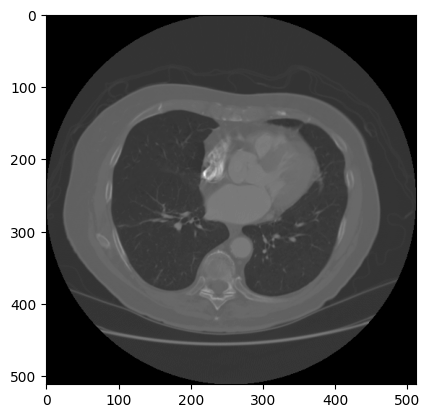

In [31]:
plt.imshow(vol[:,:,round(vol_shape[2]/2)].squeeze(), cmap=plt.cm.gray)

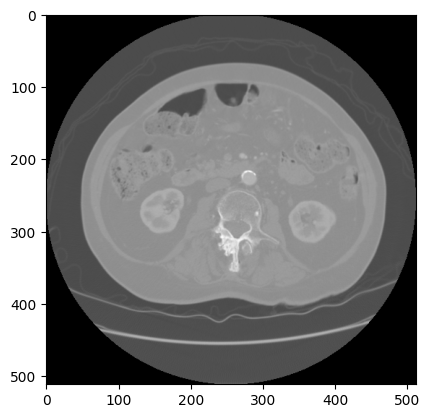

In [32]:
plt.imshow(vol[:,:,0].squeeze(), cmap=plt.cm.gray)

## Data pre-processing

In [5]:
pid = 'LIDC-IDRI-0001' # patient ID 
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first() # scan class instance for patient ID
images = scan.load_all_dicom_images(verbose=True) ## This is the list of slices for patient with id, pid. To visualize it, images[i].pixel_array.
slices = images

Loading dicom files ... This may take a moment.


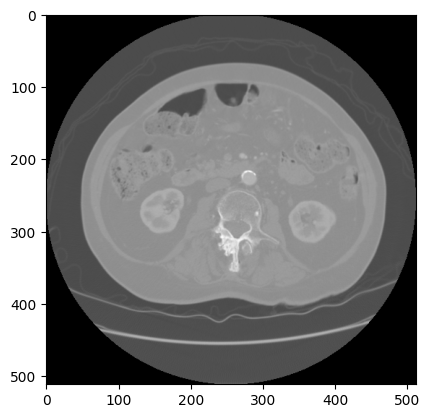

In [13]:
for i in range(0,3):
    image = images[i].pixel_array
    plt.imshow(image, cmap=plt.cm.gray)
    plt.show()

In [65]:
# Convert to Hounsfield units (HU)

def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])

    image = image.astype(np.int16)

    image[image == -2000] = 0
    
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

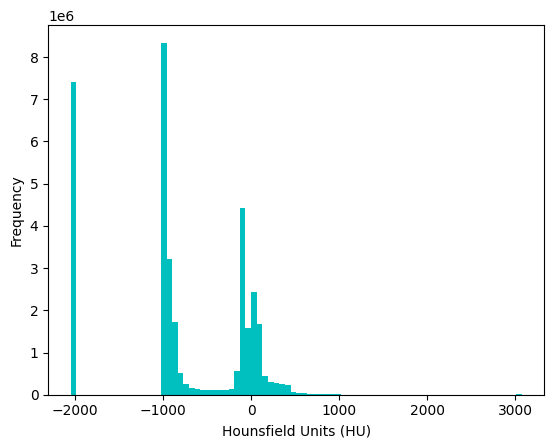

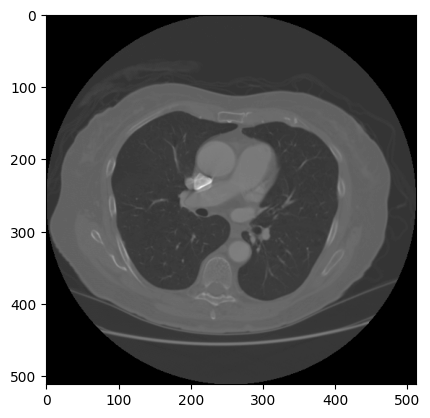

In [67]:
first_patient = slices 
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()


plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
plt.show()

In [69]:
import scipy.ndimage
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + list(scan[0].PixelSpacing), dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)


C:\Users\hp\AppData\Local\Temp\ipykernel_22072\2288961363.py:12: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')


Shape before resampling	 (133, 512, 512)
Shape after resampling	 (332, 360, 360)


### Compute x-ray projections and create Annotations Gold Standard

Compute x-ray projections from CT volumes. Also, create a volume with the annotations.

In [71]:
### parameters of the geometry of projection
# We use diff DRR made to have differentiable DRR from CT volumes. Diff DRR is customized for cone-beam CTs
# https://github.com/eigenvivek/DiffDRR

sdr = 750  ## source-to-detector radius 
height = 1024 ### size of the projected image
delx = (4*200)/height
spacing = np.array([scan.pixel_spacing,scan.pixel_spacing, scan.slice_spacing])
print(f"CT voxel resolution is {spacing} mm")

# Initialize the DRR module for generating synthetic X-rays
#device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Found torch device is {device}")

### poses of camera to create projections ### this provides the geometric constraint
### Diff DRR being created for a cone beam CT, lets try these
# Set the camera pose with rotation (yaw, pitch, roll) and translation (x, y, z)
#rotation = torch.tensor([[torch.pi, 0.0, torch.pi / 2]], device=device)
rot_x=0.0
rot_y=0.0
rot_z=3*torch.pi/2
rotation = torch.tensor([[rot_x, rot_y, rot_z]], device=device)

bx, by, bz = torch.tensor(vol.shape) * torch.tensor(spacing) / 2 ### center of the CT volume in mm
translation = torch.tensor([[bx, by, bz]], device=device) ### TO CHECK how this defines the camera pose according to the diffDRR package

CT voxel resolution is [0.703125 0.703125 2.5     ] mm
Found torch device is cpu


In [37]:
ann = pl.query(pl.Annotation).filter(pl.Annotation.scan.has(pl.Scan.patient_id == "LIDC-IDRI-0001")).first()
vol = ann.scan.to_volume()

padding = [(30,10), (10,25), (0,0)]

mask = ann.boolean_mask(pad=padding)
bbox = ann.bbox(pad=padding)

print(bbox[0])

Loading dicom files ... This may take a moment.


slice(310, 400, None)


## Visualize annotations

Loading dicom files ... This may take a moment.


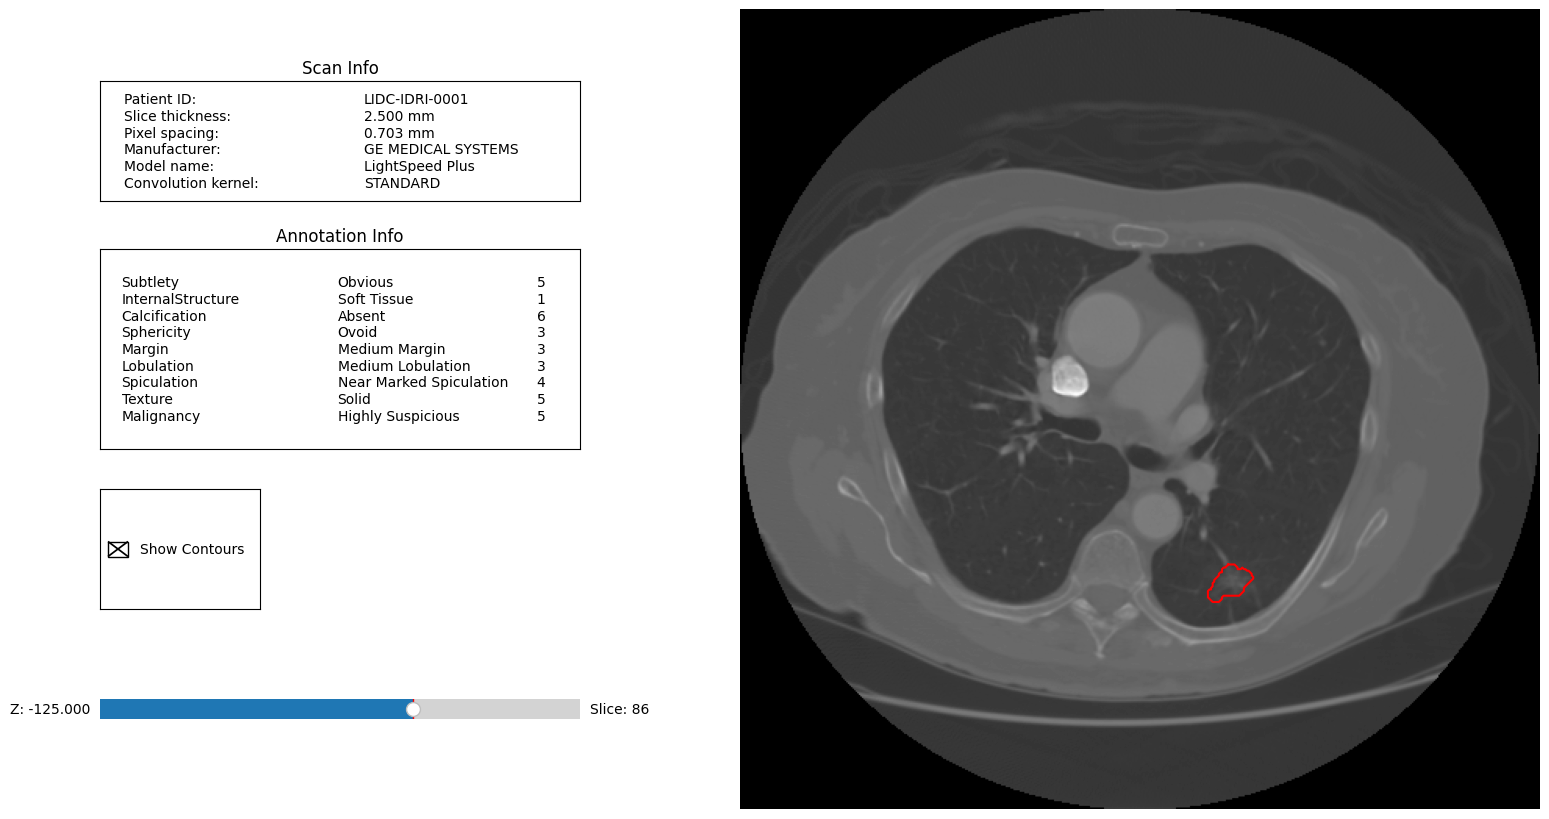

In [38]:
ann = pl.query(pl.Annotation).filter(pl.Annotation.scan.has(pl.Scan.patient_id == "LIDC-IDRI-0001")).first()
ann.visualize_in_scan()

Loading dicom files ... This may take a moment.


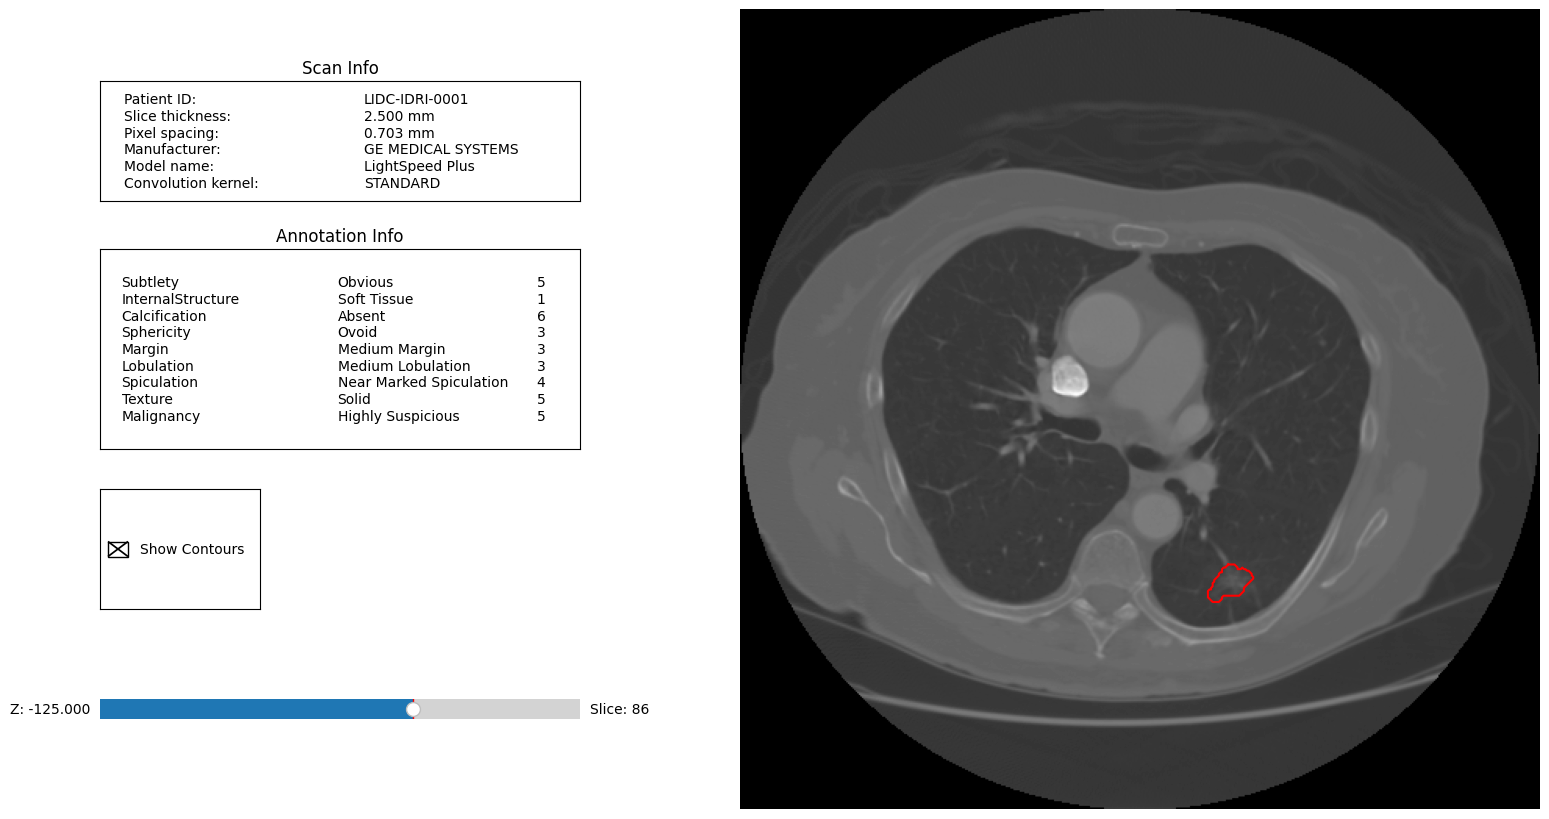

Loading dicom files ... This may take a moment.


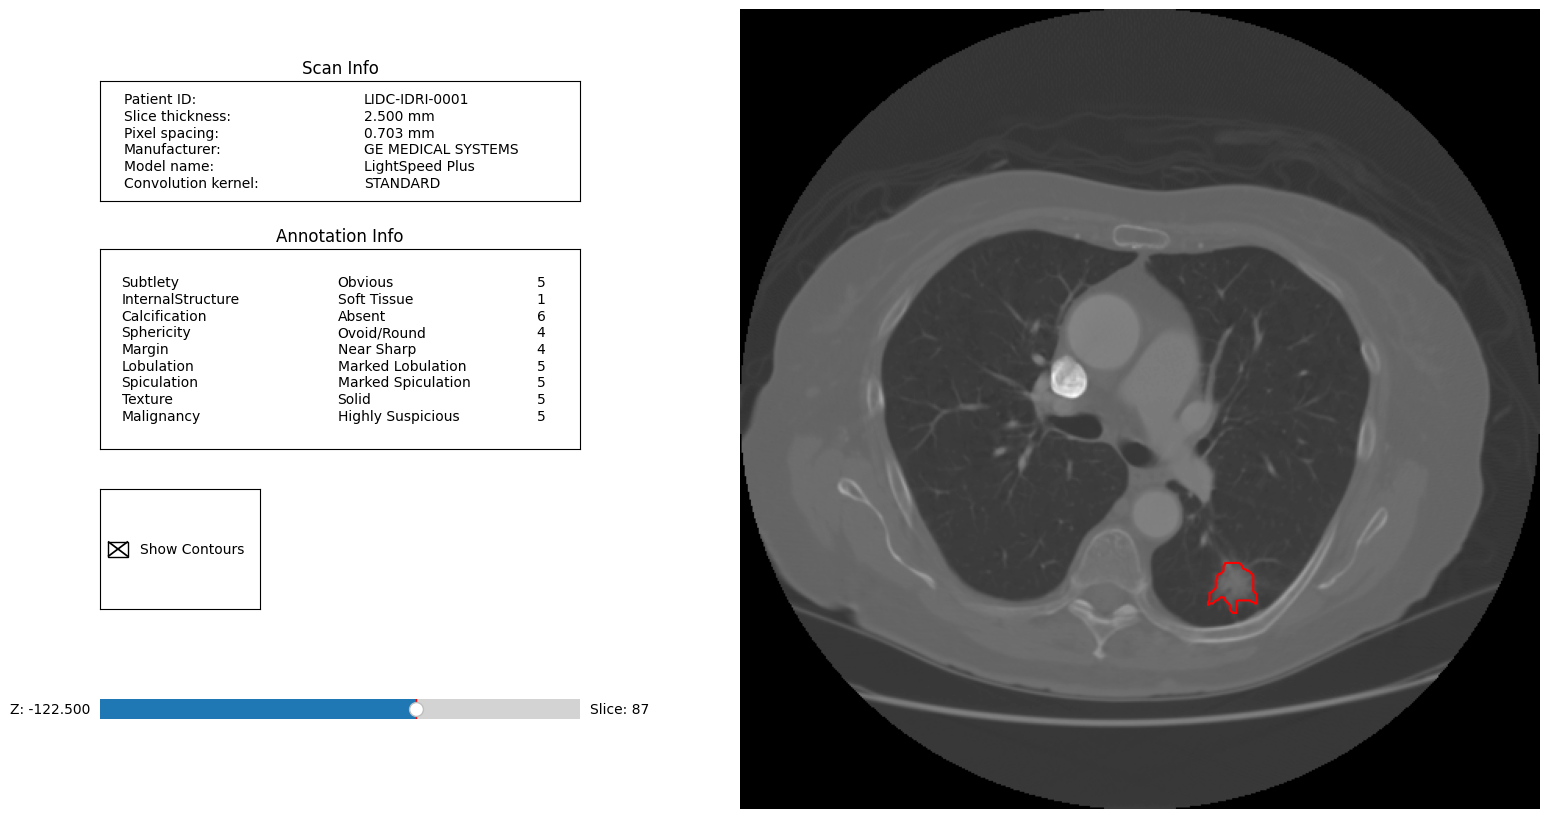

Loading dicom files ... This may take a moment.


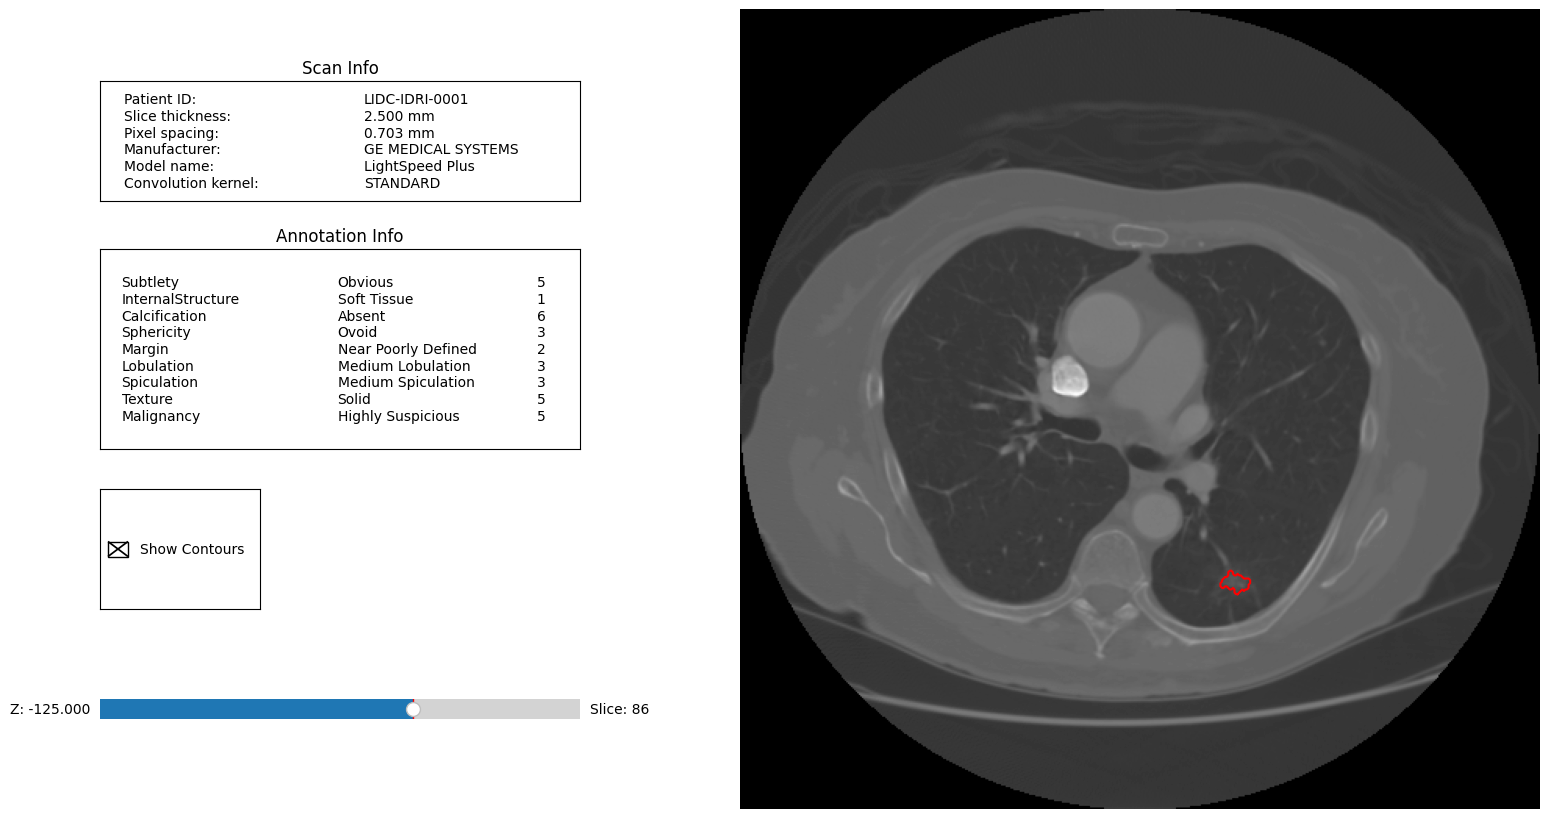

Loading dicom files ... This may take a moment.


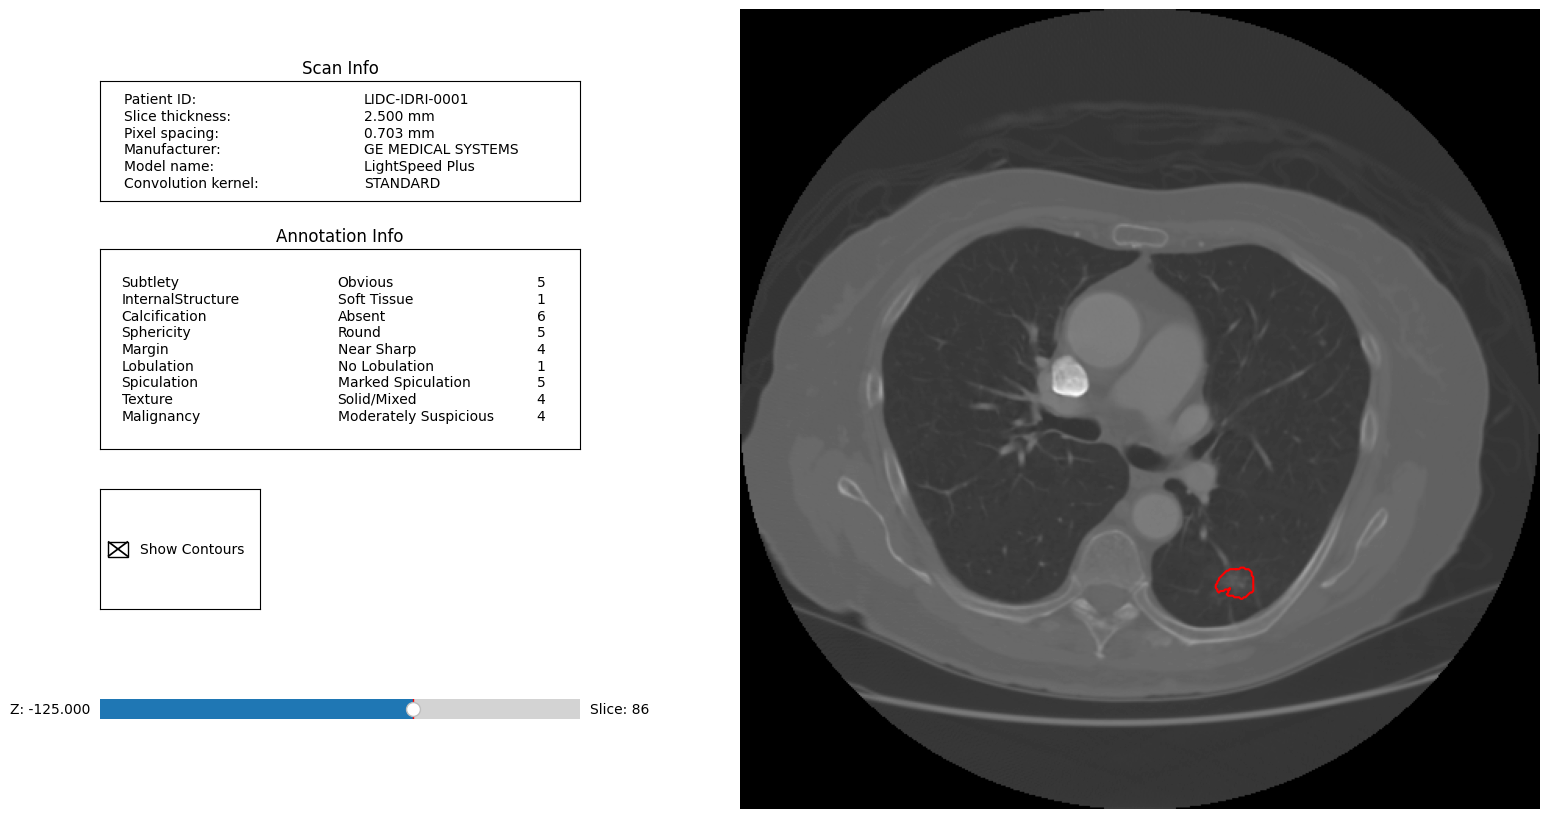

In [62]:
anns = pl.query(pl.Annotation).filter(pl.Annotation.scan.has(pl.Scan.patient_id == "LIDC-IDRI-0001")).all()

for ann in anns:
    ann.visualize_in_scan()

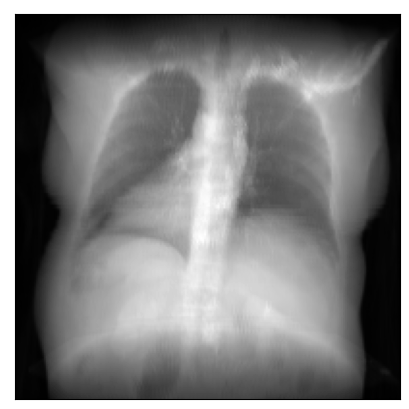

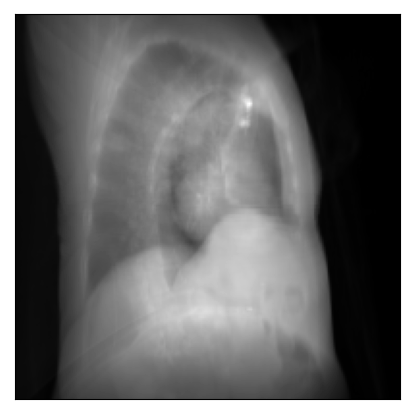

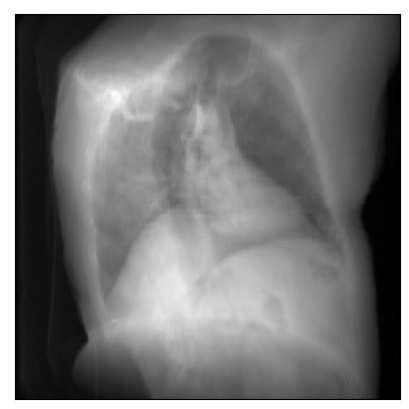

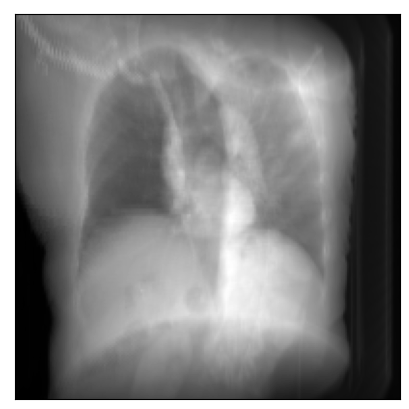

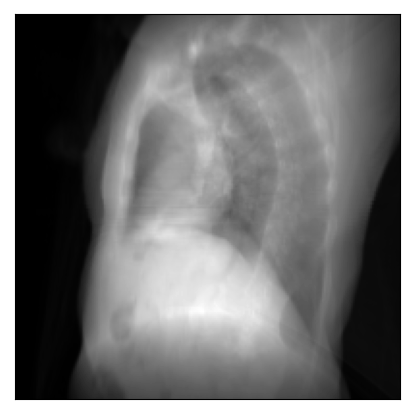

In [40]:
# Read in the volume and get the isocenter
volume, spacing = load_example_ct()
bx, by, bz = torch.tensor(volume.shape, dtype=torch.double) * \
    torch.tensor(spacing, dtype=torch.double) / 2

# Initialize the DRR module for generating synthetic X-rays
device = "cuda" if torch.cuda.is_available() else "cpu"

drr = DRR(
    volume,      # The CT volume as a numpy array
    spacing,     # Voxel dimensions of the CT
    sdr=300.0,   # Source-to-detector radius (half of the source-to-detector distance)
    height=200,  # Height of the DRR (if width is not seperately provided, the generated image is square)
    delx=4.0,    # Pixel spacing (in mm)
).to(device)

# Set the camera pose with rotation (yaw, pitch, roll) and translation (x, y, z)
# rotation = torch.tensor([[torch.pi, 0.0, torch.pi / 2]], device=device)
# translation = torch.tensor([[bx, by, bz]], device=device)

translation = torch.tensor([[bx.item(), by.item(), bz.item()]], dtype=torch.double, device=device)


N_views = 5 
for idx_x in range(N_views):
    rad_x = idx_x*2*torch.pi/N_views
    rotation = torch.tensor([[rad_x, 0.0, torch.pi / 2]],
                            dtype=torch.double, device=device)

    # 📸 Also note that DiffDRR can take many representations of SO(3) 📸
    # For example, quaternions, rotation matrix, axis-angle, etc...
    img = drr(rotation, translation,
            parameterization="euler_angles", convention="ZYX")
    plot_drr(img, ticks=False)
    plt.show()


In [44]:
sdr = 750  ## source-to-detector radius 
height = 1024 ### size of the projected image
delx = (4*200)/height
spacing = np.array([scan.pixel_spacing,scan.pixel_spacing, scan.slice_spacing])
print(f"CT voxel resolution is {spacing} mm")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Found torch device is {device}")

### poses of camera to create projections ### this provides the geometric constraint
### Diff DRR being created for a cone beam CT, lets try these
# Set the camera pose with rotation (yaw, pitch, roll) and translation (x, y, z)
#rotation = torch.tensor([[torch.pi, 0.0, torch.pi / 2]], device=device)
rot_x=0.0
rot_y=0.0
rot_z=3*torch.pi/2
rotation = torch.tensor([[rot_x, rot_y, rot_z]], device=device)

bx, by, bz = torch.tensor(vol.shape) * torch.tensor(spacing) / 2 ### center of the CT volume in mm
translation = torch.tensor([[bx, by, bz]], device=device) ### TO CHECK how this defines the camera pose according to the diffDRR package

CT voxel resolution is [0.703125 0.703125 2.5     ] mm
Found torch device is cpu


In [57]:
print(volume.shape)

(512, 512, 133)


In [ ]:
ann = pl.query(pl.Annotation).filter(pl.Annotation.scan.has(pl.Scan.patient_id == "LIDC-IDRI-0001")).first()
vol_ann = np.zeros(volume.shape)
vol_ann[ann[0].bbox()] = 1  ### a.bbox() contains the gold standard (3D bounding box) of the localisation of each annotation 
##  vol_ann is a binary volume the same size as the CT images, where all pixels are zero outside the box containing the indications and 1 inside the box
#
## create drr object for the volume of the anotation
## create drr object from CT
drr = DRR(
    vol_ann,   # The binary volume with the annotations
    spacing,   # Voxel dimensions of the volume
    sdr=sdr,   # Source-to-detector radius (half of the source-to-detector distance)
    height=height,  # Height of the DRR (if width is not seperately provided, the generated image is square)
    delx=delx,    # Pixel spacing (in mm)
).to(device)
#
## generates the xray images 
N_views = 1
for idx_x in range(N_views):
    rad_x = idx_x*2*torch.pi/N_views
    print(rad_x)
    rotation = torch.tensor([[rad_x, rot_y , rot_z]], device=device) 

    # 📸 Also note that DiffDRR can take many representations of SO(3) 📸
    # For example, quaternions, rotation matrix, axis-angle, etc...
    img = drr(rotation, translation, parameterization="euler_angles", convention="ZYX")
    img[img>0] = 1
    ### here use your favorite tool to save the created xray images s.
    ##visualisation
    plt.figure()
    plot_drr(img, ticks=False)
    plt.show()